# Support Vector Classification
___
This is an example routine to perform support vector classification on an IRIS-like raster.


## Modules

In [1]:
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Sklearn
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# Scipy
from scipy.stats import norm

# Extras
import time
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

## Functions

In [2]:
def gaussian(x, mu, sig):
    """
        Gaussian definition
    """
    return (1.0/(sig*np.sqrt(2.0*np.pi)))*np.exp( 
            -0.5*((x-mu)/sig)**2.0) 

def mgii_profiles(xx):
    """
        Fake Mg II h&k profile generator creates 8 different profiles 
        
    """
    wk0  = 2796.2
    wk1  = 2796.8
    wk2  = 2803.2
    wk3  = 2803.8
    wcc  = 2800.0

    sig1 = 0.2
    sig2 = 0.5
    sig3 = 0.1
    sigc = 2
    
    f1   = gaussian(xx, wk0, sig1) + \
           gaussian(xx, wk1, sig1) + \
           gaussian(xx, wk2, sig1) + \
           gaussian(xx, wk3, sig1) + \
           gaussian(xx, wcc, sigc)
    f2   = gaussian(xx, wk0, sig2) + \
           gaussian(xx, wk1, sig2) + \
           gaussian(xx, wk2, sig2) + \
           gaussian(xx, wk3, sig2) + \
           gaussian(xx, wcc, sigc)
    f3   = gaussian(xx, wk0, sig1) + \
           gaussian(xx, wk1, sig2) + \
           gaussian(xx, wk2, sig1) + \
           gaussian(xx, wk3, sig2) + \
           gaussian(xx, wcc, sigc)
    f4   = gaussian(xx, wk0, sig2) + \
           gaussian(xx, wk1, sig1) + \
           gaussian(xx, wk2, sig2) + \
           gaussian(xx, wk3, sig1) + \
           gaussian(xx, wcc, sigc)
    f5   = gaussian(xx, wk0, sig3) + \
           gaussian(xx, wk1, sig3) + \
           gaussian(xx, wk2, sig3) + \
           gaussian(xx, wk3, sig3) + \
           gaussian(xx, wcc, sigc)
    f6   = gaussian(xx, wk0, sig1) + \
           gaussian(xx, wk1, sig3) + \
           gaussian(xx, wk2, sig1) + \
           gaussian(xx, wk3, sig3) + \
           gaussian(xx, wcc, sigc)
    f7   = gaussian(xx, wk0, sig3) + \
           0.8*gaussian(xx, wk1, sig3) + \
           gaussian(xx, wk2, sig3) + \
           0.8*gaussian(xx, wk3, sig3) + \
           gaussian(xx, wcc, sigc)
    f8   = gaussian(xx, wk0, sig3) + \
           gaussian(xx, wk1, sig1) + \
           gaussian(xx, wk2, sig3) + \
           gaussian(xx, wk3, sig1) + \
           gaussian(xx, wcc, sigc)
    
    return np.stack((f1, f2, f3, f4, f5, f6, f7, f8))

##  Artificial IRIS raster

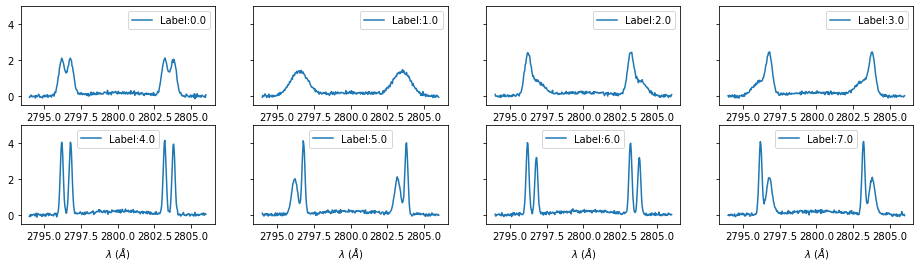

In [3]:
"""
    We create an artificial IRIS raster with eight kind of Mg II h&k profiles
"""
# 1. Wavelength aray and array with 8 kind of Mg II h&k profiles
nprof     = 8                           # Number of profiles 
nw        = 324                         # Number of elements for the wavelength array
wi        = 2794                        # Lower limit of the wavelength array
wf        = 2806                        # Upper limit of the wavelength array
iris_wl   = np.linspace(wi, wf, num=nw) # Wavelength array
ff        = mgii_profiles(iris_wl)      # Array with 8 different Mg II h&k profiles

# 2. Raster separating the 8 profiles in different regions and adding noise 
nx        = 64                          # X size of the IRIS raster
xx        = np.arange(nx)               # Array for the X coordinate
ny        = 108                         # Y size of the IRIS raster
yy        = np.arange(ny)               # Array for the Y coordinate
raster_m  = np.zeros((nx, ny, nw))      # IRIS raster
noise     = 0.05
n_samples = nx*ny
raster_t  = np.zeros((nx,ny))
    
ll       = -1
for ii in range(nx):
    if (ii % nprof == 0):
        ll+=1 
    for jj in range(ny):
        raster_m[ii,jj,:] = ff[ll] + noise*norm.ppf(np.random.rand(nw))
        raster_t[ii,jj]   = ll
    
data   = raster_m.reshape(n_samples,nw)
target = raster_t.reshape(n_samples)
#-------------------------------------------------------------------
# 3. Plot an example of each kind of profile
nrow = 2    # Number of rows for the plots
ncol = 4    # Number of columns for the plots
fig, axs = plt.subplots(nrow,ncol,figsize=(16,4), facecolor='white', sharey=True)
for kk in range(nprof):
    axs.flat[kk].set_xlabel(r"$\lambda$ ($\AA$)")
    axs.flat[kk].plot(iris_wl,raster_m[nprof*kk,100,:],
                      label="Label:"+str(raster_t[nprof*kk,100]))
    axs.flat[kk].set_ylim(-0.5,5)
    axs.flat[kk].legend()
plt.show()

## Support vector classifier

Time used by SVC: 0.884 s


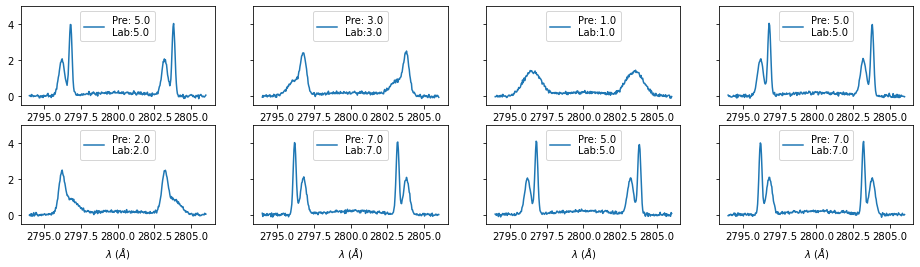

In [4]:
# 1. Initializing the time of the support vector classifier
start  = time.time()

# 2. Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# 3. Split data into 30% train and 70% test subsets
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.7, 
                                                    shuffle=True)

# 4. Learn the profile on the train subset
clf.fit(X_train, y_train)

# 5. Predict the label of the profile on the test subset
predicted = clf.predict(X_test)

# 6. Measuring the time of the support vector classifier
end    = time.time()
print('Time used by SVC: {0:.3} s'.format(end - start))

# 7. Plot an example of each kind of profile
nrow = 2    # Number of rows for the plots
ncol = 4    # Number of columns for the plots
fig, axs = plt.subplots(nrow,ncol,figsize=(16,4), facecolor='white', sharey=True)
for kk in range(nprof):
    indi = int(len(X_test)/nprof*kk)
    axs.flat[kk].set_xlabel(r"$\lambda$ ($\AA$)")
    axs.flat[kk].plot(iris_wl,X_test[indi,:],
                      label=f"Pre: {predicted[indi]}"+"\nLab:"+str(y_test[indi]))
    axs.flat[kk].set_ylim(-0.5,5)
    axs.flat[kk].legend(loc=9)
plt.show()

## Report and confussion matrix
:func:`~sklearn.metrics.classification_report` builds a text report showing
the main classification metrics.



Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       595
         1.0       1.00      1.00      1.00       602
         2.0       1.00      1.00      1.00       580
         3.0       1.00      1.00      1.00       605
         4.0       1.00      1.00      1.00       606
         5.0       1.00      1.00      1.00       601
         6.0       1.00      1.00      1.00       627
         7.0       1.00      1.00      1.00       623

    accuracy                           1.00      4839
   macro avg       1.00      1.00      1.00      4839
weighted avg       1.00      1.00      1.00      4839


Confusion matrix:
[[595   0   0   0   0   0   0   0]
 [  0 602   0   0   0   0   0   0]
 [  0   0 580   0   0   0   0   0]
 [  0   0   0 605   0   0   0   0]
 [  0   0   0   0 606   0   0   0]
 [  0   0   0   0   0 601   0   0]
 [  0   0   0   0   0   0 627   0]
 [  0   0   0   0   0   0   0 

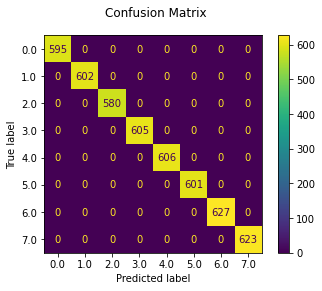

In [5]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

## Prediction for new different data

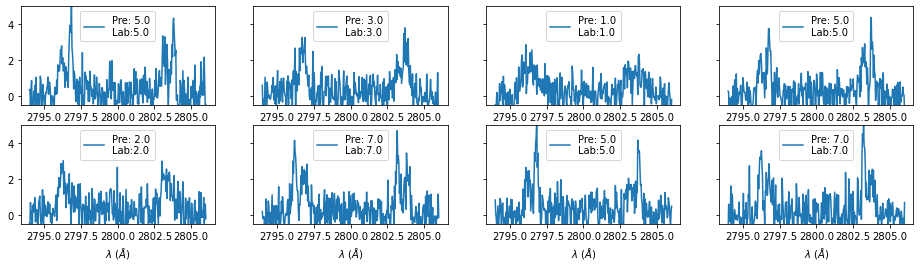

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       595
         1.0       1.00      1.00      1.00       602
         2.0       1.00      1.00      1.00       580
         3.0       1.00      1.00      1.00       605
         4.0       0.96      0.96      0.96       606
         5.0       1.00      1.00      1.00       601
         6.0       0.96      0.96      0.96       627
         7.0       1.00      1.00      1.00       623

    accuracy                           0.99      4839
   macro avg       0.99      0.99      0.99      4839
weighted avg       0.99      0.99      0.99      4839


Confusion matrix:
[[594   0   1   0   0   0   0   0]
 [  0 602   0   0   0   0   0   0]
 [  0   1 579   0   0   0   0   0]
 [  0   0   0 605   0   0   0   0]
 [  0   0   0   0 584   0  22   0]
 [  0   0   0   0   0 601   0   0]
 [  0   0   0   0  25   0 601   1]
 [  0   0   0   0   0   0   0 

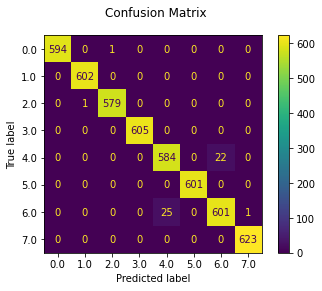

In [6]:
# 1. Predict the label of the profile on the test subset with more noise
nX_test = 1.0*X_test
noise   = 0.7
for ii in range(X_test.shape[0]):
    nX_test[ii,:] += + noise*norm.ppf(np.random.rand(nw))
newpredicted = clf.predict(nX_test)
    

# 2. Plot an example of each kind of profile
nrow = 2    # Number of rows for the plots
ncol = 4    # Number of columns for the plots
fig, axs = plt.subplots(nrow,ncol,figsize=(16,4), facecolor='white', sharey=True)
for kk in range(nprof):
    indi = int(len(nX_test)/nprof*kk)
    axs.flat[kk].set_xlabel(r"$\lambda$ ($\AA$)")
    axs.flat[kk].plot(iris_wl,nX_test[indi,:],
                      label=f"Pre: {newpredicted[indi]}"+"\nLab:"+str(y_test[indi]))
    axs.flat[kk].set_ylim(-0.5,5)
    axs.flat[kk].legend(loc=9)
plt.show()

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, newpredicted)}\n"
)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, newpredicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()